# CivitAI Models with `diffuser_tools`

## Links
* <a href = "https://huggingface.co/docs/diffusers/index">`diffusers` (HuggingFace)</a>
* <a href = "https://github.com/natsunoyuki/diffuser_tools">`diffuser_tools` (GitHub)</a>
* <a href = "https://civitai.com/models/87906/k-main">K-main (CivitAI)</a>
* <a href = "https://civitai.com/models/69158?modelVersionId=90778">Meichidark_Mix_V3.5 (CivitAI)</a>

In [1]:
try:
    import diffusers
    import transformers
    import compel
except:
    !pip install -q transformers
    !pip install -q accelerate
    !pip install -q diffusers
    !pip install -q huggingface_hub
    !pip install -q omegaconf
    !pip install -q compel
    !pip install -q peft

    import diffusers
    import transformers
    import compel
    import accelerate
    import huggingface_hub
    import omegaconf
    import peft

try:
    from diffuser_tools.text2img import Text2ImagePipe
    from diffuser_tools.utilities import plot_images
except:
    !pip install -q git+https://github.com/natsunoyuki/diffuser_tools

    from diffuser_tools.text2img import Text2ImagePipe
    from diffuser_tools.utilities import plot_images

import sys
import os
import shutil
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

if torch.backends.mps.is_available():
    device_name = torch.device("mps")
    torch_dtype = torch.float32
elif torch.cuda.is_available():
    device_name = torch.device("cuda")
    torch_dtype = torch.float16
else:
    device_name = torch.device("cpu")
    torch_dtype = torch.float32

sys.stdout.write("Using {} on {}.".format(torch_dtype, device_name));

Using torch.float16 on cuda.

# Download Model Weights

In [2]:
# kMain safetensors from civitai.
if "kMain_kMain21.safetensors" not in os.listdir("./"):
    !wget https://civitai.com/api/download/models/105253 --content-disposition

In [3]:
# Tangbohu-line LoRA from civitai.
if "tangbohu-line_1.0.safetensors" not in os.listdir("./"):
    !wget https://civitai.com/api/download/models/82894 --content-disposition

In [4]:
# easynegative textual inversion from civitai.
# https://civitai.com/models/7808/easynegative
if "easynegative.safetensors" not in os.listdir("./"):
    !wget https://civitai.com/api/download/models/9208 --content-disposition

In [5]:
# badhandv4 textual inversion from civitai.
# https://civitai.com/models/16993/badhandv4-animeillustdiffusion
if "badhandv4.pt" not in os.listdir("./"):
    !wget https://civitai.com/api/download/models/20068 --content-disposition

# Model Inference Pipeline

First perform model inference using the <a href = "https://civitai.com/models/87906?modelVersionId=105253">K-main model weights</a> downloaded directly from CivitAI. No LoRAs or textual inversion models are used. Use a CLIP-skip of 2, and the DPMSolverMultistepScheduler scheduler.

In [6]:
# Initialize model inference pipeline without LoRAs or textual inversion models.
model_path = "kMain_kMain21.safetensors"

clip_skip = 2

scheduler = "DPMSMS"
scheduler_configs = {"use_karras_sigmas": True}

prompt = """(photo-realistic,real photo,masterpiece,best quality,8k,UHD,
RAW photo,levelled out,super resolution,sharp focus,ultra detailed skin,
realistic skin,beautiful vivid backgrounds,exquisitely detailed,
colorful and intricate details,ray tracing,film lights,spot lights,
lustrous skin,physically based rendering,best illustration,best shadow,
cinematic lighting,delicate Illustration,official art,aesthetic:1.4),
(golden-ratio face,perfect proportioned face,perfectly beautiful),
standing in a garden with flowers,clear blue skies,
glossy and red lips,brown eyes,long brown hair,
(mature woman,milf,gravure idol,miss korea,korean beauty),(white string bikini),
(short torso,long legs,slim waist,huge hips,huge naturally sagging breasts:1.4),
(1girl,solo girl,solo focus),(thigh up shot,cowboy shot,side view)"""

negative_prompt = """hands,(worst quality,low quality,normal quality,
low resolution,worst resolution,normal resolution,collage),
tattoo,watermark,(Dutch angle,Dutch tilt,canted angle,vortex angle,
oblique angle:1.3),tiara,(one more girl)"""

prompt = "".join(prompt.split("\n"))
negative_prompt = "".join(negative_prompt.split("\n"))

In [ ]:
text_2_img = Text2ImagePipe(
    model_path = model_path,
    prompt = prompt,
    negative_prompt = negative_prompt,
    scheduler = scheduler,
    scheduler_configs = scheduler_configs,
    clip_skip = clip_skip,
    use_prompt_embeddings = True,
    use_compel = True,
    torch_dtype = torch_dtype,
    device = device_name
)

In [ ]:
start_seed = 5
N_imgs = 5

seeds = [i for i in range(start_seed, start_seed + N_imgs)]
images = []
for seed in seeds:
    image = text_2_img.run_pipe(
        steps = 30,
        width = 512,
        height = 832,
        scale = 7,
        seed = seed,
        use_prompt_embeddings = True,
        verbose = False
    )
    images.append(image)

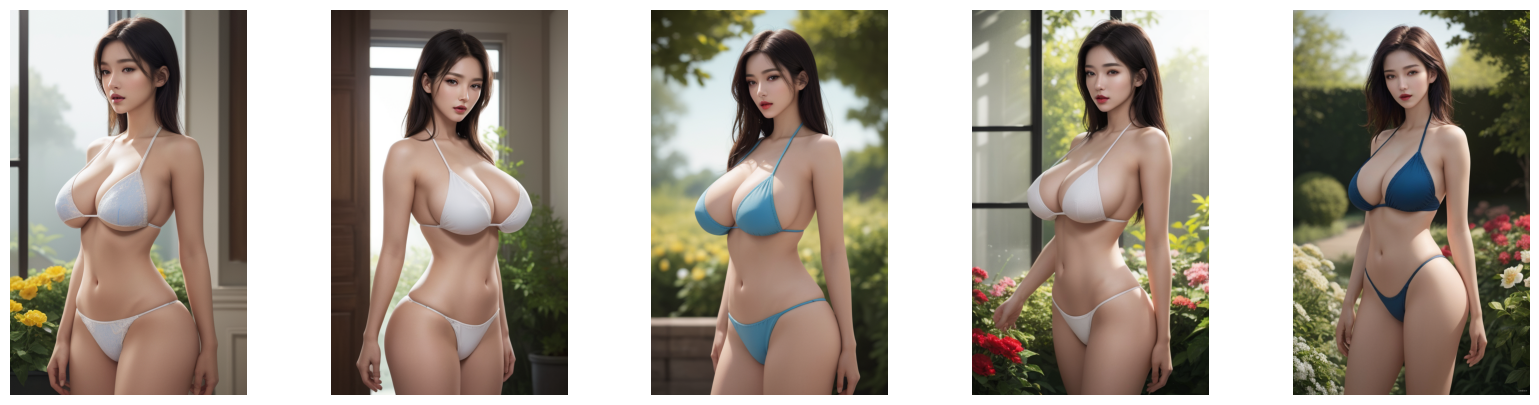

In [9]:
plot_images(images)

# Using LoRAs During Model Inference

In addition to the original settings above, use the <a href = "https://civitai.com/models/78118?modelVersionId=82894">tangbohu-line LoRA</a> downloaded from CivitAi to further enhance the output images. A LoRA scale of 0.7 is used. Using this LoRA results in images with more contrast and line details compared to the originals.

In [10]:
# Specify lora .safetensor paths, adapter names and scale.
lora_paths = ["tangbohu-line_1.0.safetensors"]
lora_adapter_names = ["tangbohu-line"]
lora_scales = [0.7]

In [ ]:
# Re-initialize pipeline with LoRAs.
text_2_img = Text2ImagePipe(
    model_path = model_path,
    prompt = prompt,
    negative_prompt = negative_prompt,
    lora_paths = lora_paths,
    lora_adapter_names = lora_adapter_names,
    lora_scales = lora_scales,
    scheduler = scheduler,
    scheduler_configs = scheduler_configs,
    clip_skip = clip_skip,
    use_prompt_embeddings = True,
    use_compel = True,
    torch_dtype = torch_dtype,
    device = device_name
)

In [ ]:
images_1 = []
for seed in seeds:
    image = text_2_img.run_pipe(
        steps = 30,
        width = 512,
        height = 832,
        scale = 7,
        seed = seed,
        use_prompt_embeddings = True,
        verbose = False
    )
    images_1.append(image)

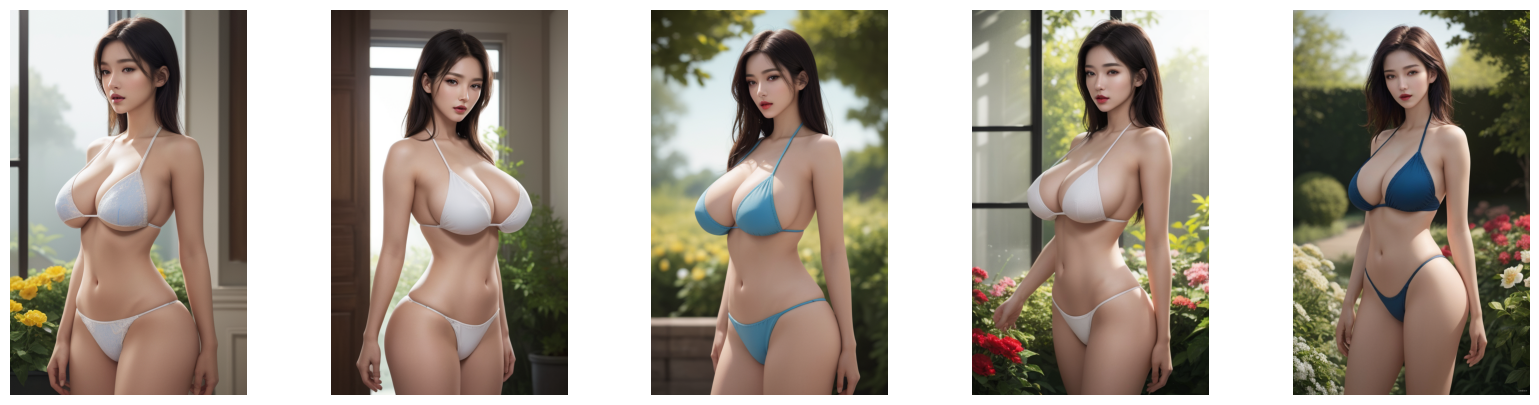

In [13]:
# Original.
plot_images(images)

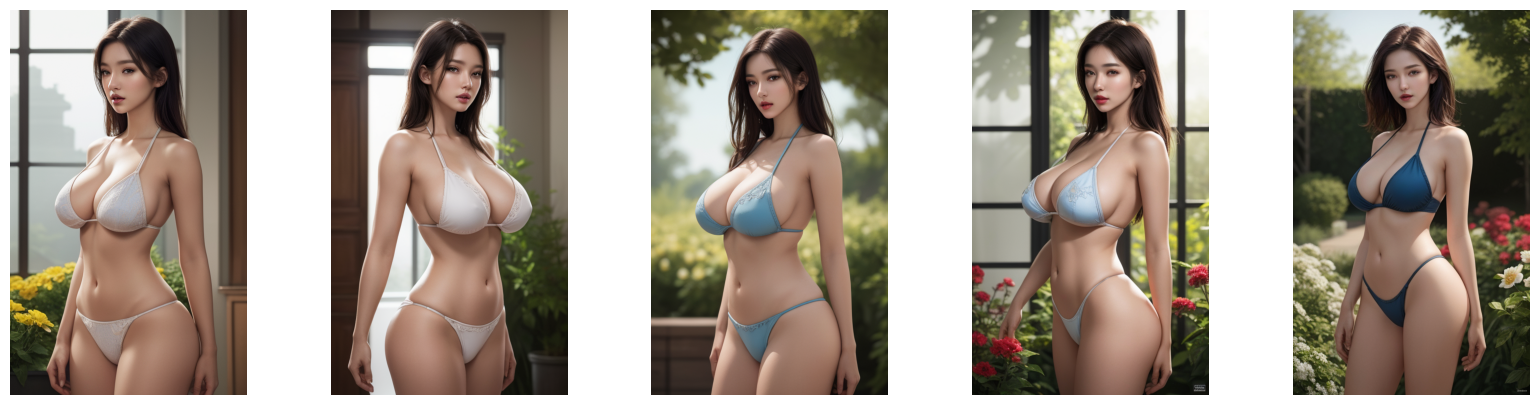

In [14]:
# With LoRA.
plot_images(images_1)

# Using Textual Inversions During Model Inference

In addition to the original settings above, use both the <a href = "https://civitai.com/models/7808?modelVersionId=9208">easynegative textual inversion</a> and <a href = "https://civitai.com/models/16993?modelVersionId=20068">badhandv4 textual inversion</a> models to further enhance the generated images. No other LoRAs are used for now.

In [15]:
# Specify textual inversion paths and tokens.
textual_inversion_paths = ["easynegative.safetensors", "badhandv4.pt"]
textual_inversion_tokens = ["easynegative", "badhandv4"]

# Initialize model inference pipeline without LoRAs or textual inversion models.
# Add the required textual inversion tokens to the prompts as required.
prompt = """(photo-realistic,real photo,masterpiece,best quality,8k,UHD,
RAW photo,levelled out,super resolution,sharp focus,ultra detailed skin,
realistic skin,beautiful vivid backgrounds,exquisitely detailed,
colorful and intricate details,ray tracing,film lights,spot lights,
lustrous skin,physically based rendering,best illustration,best shadow,
cinematic lighting,delicate Illustration,official art,aesthetic:1.4),
(golden-ratio face,perfect proportioned face,perfectly beautiful),
standing in a garden with flowers,clear blue skies,
glossy and red lips,brown eyes,long brown hair,
(mature woman,milf,gravure idol,miss korea,korean beauty),(white string bikini),
(short torso,long legs,slim waist,huge hips,huge naturally sagging breasts:1.4),
(1girl,solo girl,solo focus),(thigh up shot,cowboy shot,side view)"""

negative_prompt = """hands,(worst quality,low quality,normal quality,
low resolution,worst resolution,normal resolution,collage),
tattoo,watermark,(Dutch angle,Dutch tilt,canted angle,vortex angle,
oblique angle:1.3),tiara,(one more girl),easynegative,badhandv4"""

prompt = "".join(prompt.split("\n"))
negative_prompt = "".join(negative_prompt.split("\n"))

In [ ]:
# Re-initialize pipeline with textual inversions.
text_2_img = Text2ImagePipe(
    model_path = model_path,
    prompt = prompt,
    negative_prompt = negative_prompt,
    textual_inversion_paths = textual_inversion_paths,
    textual_inversion_tokens = textual_inversion_tokens,
    scheduler = scheduler,
    scheduler_configs = scheduler_configs,
    clip_skip = clip_skip,
    use_prompt_embeddings = True,
    use_compel = True,
    torch_dtype = torch_dtype,
    device = device_name
)

In [ ]:
images_2 = []
for seed in seeds:
    image = text_2_img.run_pipe(
        steps = 30,
        width = 512,
        height = 832,
        scale = 7,
        seed = seed,
        use_prompt_embeddings = True,
        verbose = False
    )
    images_2.append(image)

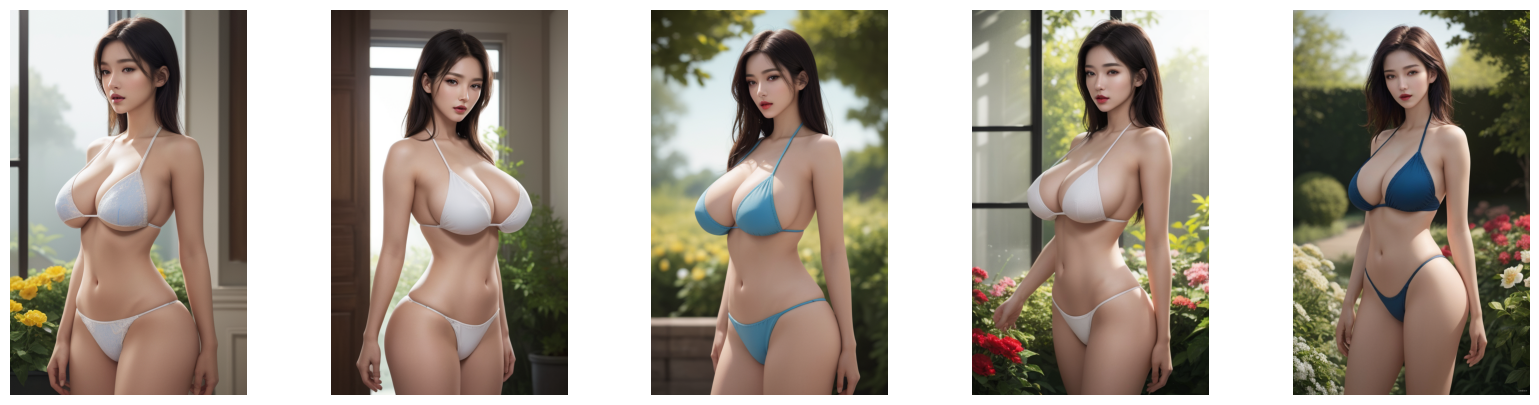

In [18]:
# Original.
plot_images(images)

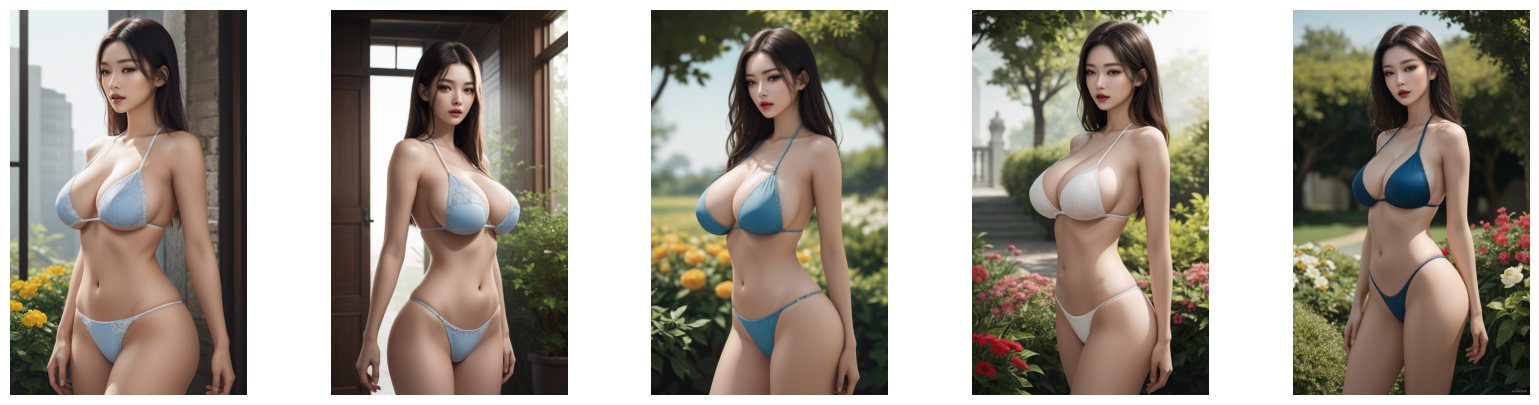

In [19]:
# With textual inversions.
plot_images(images_2)

# Using LoRAs and Textual Inversions During Model Inference

Finally, use LoRAs and textual inversions together during model inference to combine their effects. By combining different LoRAs and textual inversion models with different stable diffusion models, it is possible to create images which are different from the originals.

In [ ]:
# Reload pipeline with LoRAs and textual inversions.
text_2_img = Text2ImagePipe(
    model_path = model_path,
    prompt = prompt,
    negative_prompt = negative_prompt,
    lora_paths = lora_paths,
    lora_adapter_names = lora_adapter_names,
    lora_scales = lora_scales,
    scheduler = scheduler,
    scheduler_configs = scheduler_configs,
    clip_skip = clip_skip,
    textual_inversion_paths = textual_inversion_paths,
    textual_inversion_tokens = textual_inversion_tokens,
    use_prompt_embeddings = True,
    use_compel = True,
    torch_dtype = torch_dtype,
    device = device_name
)

In [ ]:
images_3 = []
for seed in seeds:
    image = text_2_img.run_pipe(
        steps = 30,
        width = 512,
        height = 832,
        scale = 7,
        seed = seed,
        use_prompt_embeddings = True,
        verbose = False
    )
    images_3.append(image)

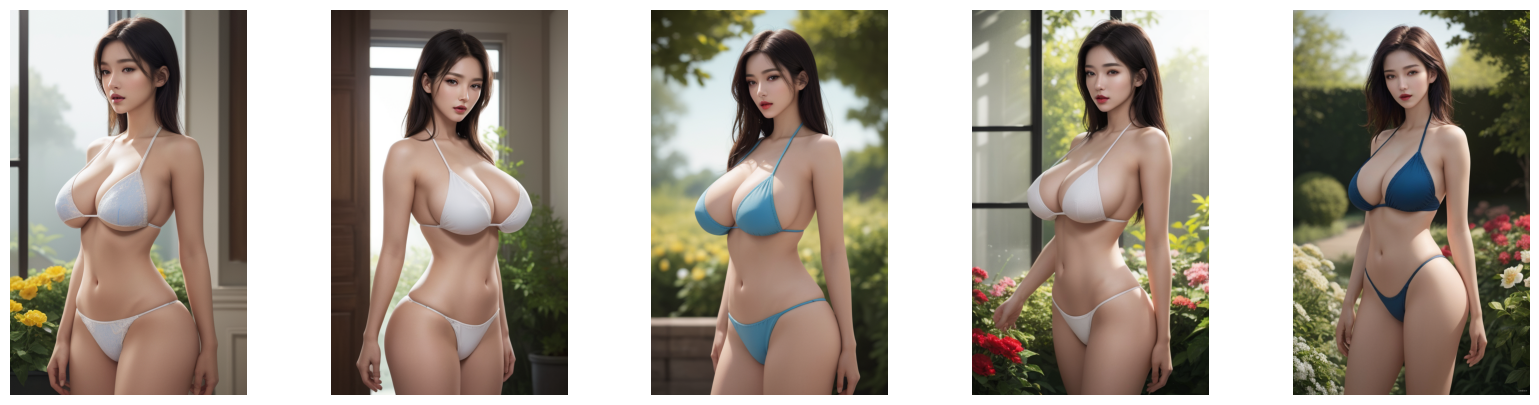

In [22]:
# Original.
plot_images(images)

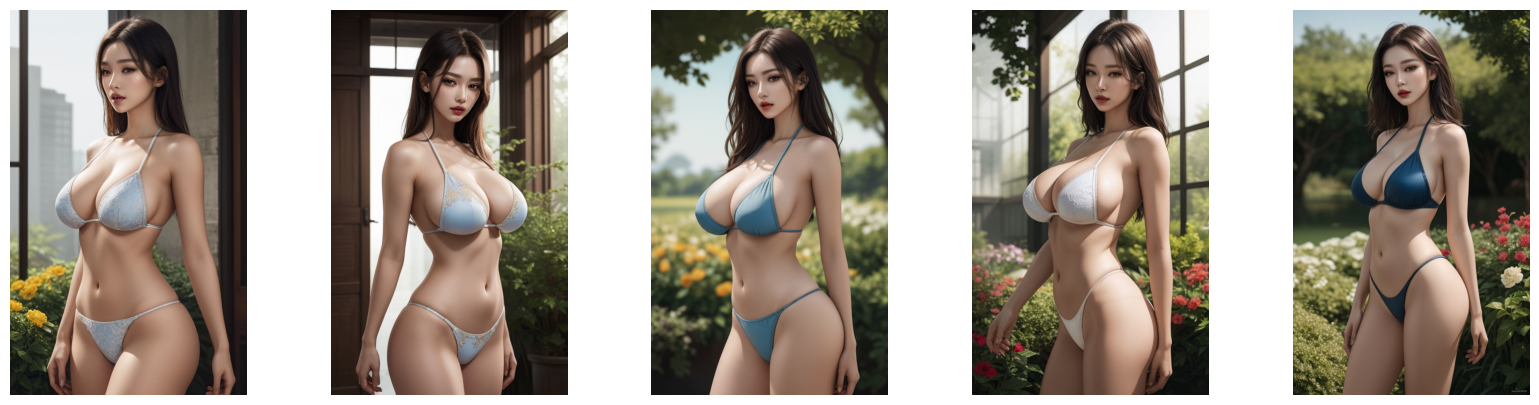

In [23]:
# With LoRA and textual inversions.
plot_images(images_3)